<a href="https://colab.research.google.com/github/Venura-Shiromal/NASA-Space-Apps-2025/blob/main/K2_ClassificationModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Prerequisities

In [ ]:
# just in case if needed
# !pip install catboost

In [25]:
import pandas as pd
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

## Loading Data

In [26]:
k2 = pd.read_csv('sample_data/k2pandc_2025.09.26_11.17.56.csv', comment='#')
k2.head()

,pl_name,hostname,default_flag,disposition,disp_refname,sy_snum,sy_pnum,discoverymethod,disc_year,disc_facility,...,sy_vmagerr2,sy_kmag,sy_kmagerr1,sy_kmagerr2,sy_gaiamag,sy_gaiamagerr1,sy_gaiamagerr2,rowupdate,pl_pubdate,releasedate
0,BD+20 594 b,BD+20 594,0,CONFIRMED,Espinoza et al. 2016,1.0,1.0,Transit,2016.0,K2,...,-0.012,9.368,0.018,-0.018,10.8644,0.000249,-0.000249,2018-04-25,2018-03,2018-02-15
1,BD+20 594 b,BD+20 594,0,CONFIRMED,Espinoza et al. 2016,1.0,1.0,Transit,2016.0,K2,...,-0.012,9.368,0.018,-0.018,10.8644,0.000249,-0.000249,2018-04-25,2016-10,2016-07-28
2,BD+20 594 b,BD+20 594,1,CONFIRMED,Espinoza et al. 2016,1.0,1.0,Transit,2016.0,K2,...,-0.012,9.368,0.018,-0.018,10.8644,0.000249,-0.000249,2018-04-25,2017-03,2018-04-26
3,EPIC 201111557.01,EPIC 201111557,1,CANDIDATE,Livingston et al. 2018,1.0,0.0,Transit,2018.0,K2,...,-0.046,9.220,0.019,-0.019,11.3995,0.001307,-0.001307,2018-08-02,2018-08,2018-08-02
4,EPIC 201111557.01,EPIC 201111557,0,CANDIDATE,Livingston et al. 2018,1.0,0.0,Transit,2018.0,K2,...,-0.046,9.220,0.019,-0.019,11.3995,0.001307,-0.001307,2018-02-15,2018-03,2018-02-15


## Feature Selection

In [27]:
features = [
    "pl_orbper",
    "pl_orbsmax",
    "pl_rade",
    "pl_radj",
    "pl_bmasse",
    "pl_bmassj",
    "pl_orbeccen",
    "pl_insol",
    "pl_eqt",
    "st_teff",
    "st_rad",
    "st_mass",
    "st_met",
    "st_logg",

    "disposition",

    "discoverymethod",
    "disc_year",
    "sy_dist",
    "st_spectype"
]
print(k2["disposition"].unique())

['CONFIRMED' 'CANDIDATE' 'FALSE POSITIVE' 'REFUTED']


Label Mapping

In [29]:
label_map = {
    'CONFIRMED': 1,   # Confirmed Planet
    'CANDIDATE': 0,   # Planetary Candidate
    'FALSE POSITIVE': -1,  # False Positive
    'REFUTED': -1   # False Alarm
}

k2["disposition"] = k2["disposition"].map(label_map)

In [30]:
k2 = k2[features]
k2.head()

,pl_orbper,pl_orbsmax,pl_rade,pl_radj,pl_bmasse,pl_bmassj,pl_orbeccen,pl_insol,pl_eqt,st_teff,st_rad,st_mass,st_met,st_logg,disposition,discoverymethod,disc_year,sy_dist,st_spectype
0,41.688644,NaN,2.355454,0.210139,NaN,NaN,NaN,NaN,NaN,5703.00,0.956122,0.963861,-0.06,4.38000,1,Transit,2016.0,179.4610,NaN
1,41.685500,0.241,2.230000,0.198947,16.3000,0.051285,0.0,NaN,546.0,5766.00,0.928000,0.961000,-0.15,4.50000,1,Transit,2016.0,179.4610,G
2,41.685500,NaN,2.578070,0.230000,22.2481,0.070000,0.0,NaN,NaN,5766.00,1.080000,1.670000,-0.15,4.50000,1,Transit,2016.0,179.4610,NaN
3,2.301830,NaN,1.120000,0.099900,NaN,NaN,NaN,NaN,1054.0,4616.52,0.762602,0.730000,-0.03,4.53679,0,Transit,2018.0,97.1795,NaN
4,2.302368,NaN,1.312588,0.120000,NaN,NaN,NaN,NaN,NaN,4720.00,0.710995,NaN,-0.06,4.50000,0,Transit,2018.0,97.1795,NaN


## Filling empty cells

In [31]:
numerical_cols = [
    "pl_orbper", "pl_orbsmax", "pl_rade", "pl_radj",
    "pl_bmasse", "pl_bmassj", "pl_orbeccen", "pl_insol", "pl_eqt",
    "st_teff", "st_rad", "st_mass", "st_met", "st_logg",
    "sy_dist"
]

categorical_cols = [
    "discoverymethod", "disc_year", "st_spectype"
]

for col in numerical_cols:
    k2[col].fillna(k2[col].median(), inplace=True)

for col in categorical_cols:
    k2[col].fillna(k2[col].mode()[0], inplace=True)

/tmp/ipython-input-3308888265.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  k2[col].fillna(k2[col].median(), inplace=True)
/tmp/ipython-input-3308888265.py:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try us

### Checking if NaN available

In [32]:
print(k2.isna().sum())

pl_orbper          0
pl_orbsmax         0
pl_rade            0
pl_radj            0
pl_bmasse          0
pl_bmassj          0
pl_orbeccen        0
pl_insol           0
pl_eqt             0
st_teff            0
st_rad             0
st_mass            0
st_met             0
st_logg            0
disposition        0
discoverymethod    0
disc_year          0
sy_dist            0
st_spectype        0
dtype: int64


## Defining data sets

In [33]:
X = k2.drop("disposition", axis=1)
y = k2["disposition"]

In [34]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
    )

Defining Classes

In [35]:
classes = np.unique(y_train)

Calculating Class Weights

In [36]:
weights = compute_class_weight("balanced", classes=classes, y=y_train)

Combining both

In [37]:
class_weights = dict(zip(classes, weights))

### Cross-validation

In [38]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for train_idx, valid_idx in skf.split(X, y):
    X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
    y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

## Cat Boost Initiation

### Parameters


In [39]:
max_ite = 2500
dep = 8
l_rate = 0.01

In [40]:
model = CatBoostClassifier(
    iterations=max_ite,
    depth=dep,
    learning_rate=l_rate,
    loss_function="MultiClass",
    eval_metric="MultiClass",
    l2_leaf_reg=7,
    early_stopping_rounds=50,
    random_seed=42,
    verbose=50,
    class_weights=class_weights
)


# Training

In [ ]:
model.fit(X_train, y_train, eval_set=(X_test, y_test))

0:	learn: 1.0954046	test: 1.0954694	best: 1.0954694 (0)	total: 219ms	remaining: 9m 6s
50:	learn: 0.9746021	test: 0.9753692	best: 0.9753692 (50)	total: 2.14s	remaining: 1m 42s
100:	learn: 0.9045325	test: 0.9060901	best: 0.9060901 (100)	total: 3.88s	remaining: 1m 32s
150:	learn: 0.8600109	test: 0.8621513	best: 0.8621513 (150)	total: 5.61s	remaining: 1m 27s
200:	learn: 0.8271665	test: 0.8301611	best: 0.8301611 (200)	total: 8.01s	remaining: 1m 31s
250:	learn: 0.8022124	test: 0.8058478	best: 0.8058478 (250)	total: 10.8s	remaining: 1m 37s
300:	learn: 0.7817909	test: 0.7858551	best: 0.7858551 (300)	total: 13.7s	remaining: 1m 39s
350:	learn: 0.7653542	test: 0.7701819	best: 0.7701819 (350)	total: 15.4s	remaining: 1m 34s
400:	learn: 0.7510467	test: 0.7569731	best: 0.7569731 (400)	total: 17.1s	remaining: 1m 29s
450:	learn: 0.7379723	test: 0.7445267	best: 0.7445267 (450)	total: 18.8s	remaining: 1m 25s
500:	learn: 0.7255363	test: 0.7332411	best: 0.7332411 (500)	total: 20.5s	remaining: 1m 21s
550:	l

### Plotting Loss

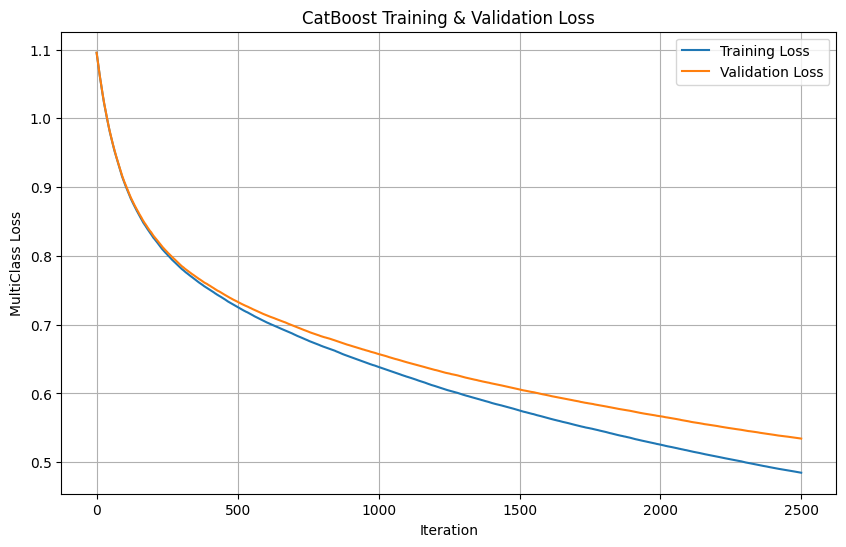

In [ ]:
evals_result = model.get_evals_result()

train_loss = evals_result['learn']['MultiClass']
valid_loss = evals_result['validation']['MultiClass']

plt.figure(figsize=(10,6))
plt.plot(train_loss, label='Training Loss')
plt.plot(valid_loss, label='Validation Loss')
plt.xlabel('Iteration')
plt.ylabel('MultiClass Loss')
plt.title('CatBoost Training & Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Evaluation

In [ ]:
y_pred = model.predict(X_test)

### Confusion Matrix

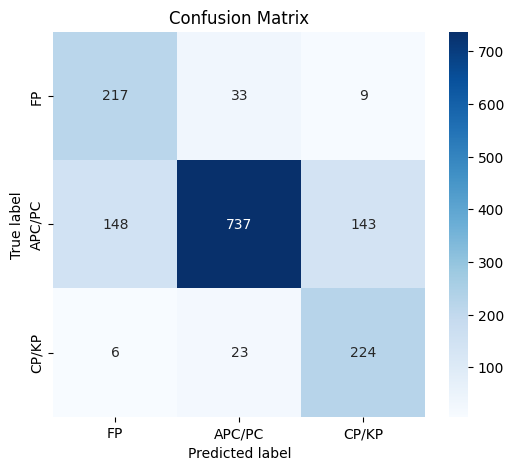

In [ ]:
cm = confusion_matrix(y_test, y_pred)

class_names = ["FP", "APC/PC", "CP/KP"]

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
plt.show()

Accuracy

In [ ]:
acc = accuracy_score(y_test, y_pred)
print("Accuracy: {:.2f}%".format(acc * 100))

Accuracy: 76.49%
